# IMPORT LIBRARY

In [2]:
!pip install transformers

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

# PENGATURAN KONFIGURASI

In [4]:
# Menetapkan model 
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# menggunakan GPU "cuda" jika tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# memuat tokenizer BERT yang sesuai dengan model pra-terlatih
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# menetapkan jumlah epoch untuk pelatihan model
EPOCHS=10
# menetapkan panjang maksimum urutan token (kata) yang akan diproses oleh model
MAX_LEN=512
# menetapkan batch size
BATCH_SIZE=16

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# MEMBACA DATA

In [5]:
# membaca kolom msg dan spam pada file CSV dari URL
df = pd.read_csv('https://raw.githubusercontent.com/animesharma3/SPAM-SMS-Detection/master/spam_sms_collection.csv')[['msg', 'spam']]
# menampilkan 5 data teratas
print(df.head().to_string(index=False))

                                                                                                  msg  spam
                   go jurong point crazy available bugis n great world la e buffet cine got amore wat     0
                                                                              ok lar joking wif u oni     0
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply     1
                                                                  u dun say early hor u c already say     0
                                                                  nah think go usf life around though     0


In [6]:
df.shape

(5572, 2)

# MENDEFINISIKAN DATASET

In [7]:
# KODE MEMBUAT CLASS UNTUK MENYIAPKAN DATASET DENGAN BAIK
# DATASET YANG TELAH DIOLAH DENGAN MODEL YANG TELAH DILATIH SEBELUMNYA
# Definisi kelas SMSCollectionDataset yang merupakan turunan dari Dataset
class SMSCollectionDataset(Dataset):
    # membuat method inisialisasinya dataset
    def __init__(self, spam, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.spam = spam
        self.tokenizer = tokenizer
        self.max_len = max_len

    # membuat method untuk menyimpan panjang maksimum untuk tokenisasi dataset
    def __len__(self):
        return len(self.msgs)
    
    # membuat method untuk mengambil elemen ke-i dari dataset
    def __getitem__(self, i):
        # mengambil elemen msg ke-i
        msg = str(self.msgs[i])
        # mengambil elemen spam ke-i
        spam = self.spam[i]

        # melakukan encoding pada msg dengan menggunakan tokenizer untuk mengubah teks menjadi token.
        encoding = self.tokenizer.encode_plus(
            msg, 
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,# menunjukkan bagian mana dari urutan yang merupakan padding.
            return_tensors='pt'
        )

        # mengembalikan dict yg berisi msg, ID Token yang dihasilkan dari tokenizer, attention_mask, dan spam
        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'spam': torch.tensor(spam, dtype=torch.long)
        }

# MEMBUAT DATA LOADER (BATCH)

In [8]:
# MENDEFINISIKAN FUNGSI UNTUK DATASET LOADER YANG BAIK karena datanya banyak
# mendefinisikan fungsi membuat data loader dari dataset
def create_data_loader(df, tokenizer, max_len, batch_size):
    # membuat instance dari SMSCollectionDataset
    ds = SMSCollectionDataset(
        spam=df['spam'].to_numpy(),
        msgs=df['msg'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    # mengembalikan DataLoader yang berisi data-data yang telah diolah sebelumnya.
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4 # jumlah pekerja untuk proses paralel DataLoader
    )

# MEMBAGI DATA 

In [9]:
# membagi dataset menjadi 80% data untuk latih dan 20% untuk data tes
df_train, df_test = tts(
    df,
    test_size=0.2, # kuncinya 20% utk tes
    random_state=42 # nilai acaknya
)
# membagi data tes menjadi 50% data validasi dan 50% data tes
df_val, df_test = tts(
    df_test,
    test_size=0.5,
    random_state=42
)
# menampilkan ukuran data latih, validasi, dan tes
df_train.shape, df_test.shape, df_val.shape

((4457, 2), (558, 2), (557, 2))

# MEMBUAT DATA LOADER UNTUK SETIAP BAGIAN DATA

In [10]:
# membuat data loader untuk data latih
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
# membuat data loader untuk data validasi
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
# membuat data loader untuk data tes
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

# MEMERIKSA SATU BATCH DATA PELATIHAN

In [11]:
# memanipulasi data dalam batch dengan lebih mudah
d = next(iter(train_data_loader)) # mengambil 1 batch pertama
d.keys()

dict_keys(['msg', 'input_ids', 'attention_mask', 'spam'])

In [12]:
# memeriksa dimensi dari setiap elemen dalam satu batch data
d['input_ids'].shape, d['attention_mask'].shape, d['spam'].shape

(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16]))

# MEMBANGUN MODEL

In [13]:
# mendeklarasikan sebuah kelas SpamClassifier yang merupakan turunan dari nn.Module
class SpamClassifier(nn.Module):
    def __init__(self, n_classes):
        # memanggil constructor dari kelas dasar (nn.Module)
        super(SpamClassifier, self).__init__()
        # menginisialisasi model BERT yang sudah dilatih sebelumnya
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        # mendefinisikan lapisan dropout dengan probabilitas 30% (mencegah overfitting)
        self.drop = nn.Dropout(p=0.3)
        # mendefinisikan layer output (spam or not spam)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # mendefinisikan metode forward
    def forward(self, input_ids, attention_mask):
        # mengoper input input_ids dan attention_mask melalui model BERT
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        # mendefinisikan output dengan menerapkan lapisan dropout untuk mencegah overfitting
        output = self.drop(pooled_output)
        # mengembalikan output
        return self.out(output)

# MEMASTIKAN MODEL MENGGUNAKAN PERANGKAT YANG OPTIMAL

In [14]:
# membuat instance SpamClassifier
model = SpamClassifier(n_classes=2)
# memindahkan model ke GPU or CPU
model = model.to(device)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

# INISIALISASI OPTIMIZER, SCHEDULER, DAN LOSS

In [15]:
# menggunakan optimizer AdamW, learning rate = 0.00002
# correct_bias = false (bias tidak harus diperbaiki)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# mendefinisikan total step (banyak pembaharuan)
total_steps = len(train_data_loader) * EPOCHS

# membuat scheduler agar sesi training menjadi dinamis sesuai dengan kondisi
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps # Total jumlah langkah pelatihan.
)
# mendefinisikan metode menghitung loss dan memindahkannya ke GPU or CPU
loss_fn = nn.CrossEntropyLoss().to(device)

# MENDEFINISIKAN FUNGSI TRAIN UNTUK MELATIH MODEL

In [16]:
# mendefinisikan fungsi train untuk menghitung loss, melakukan propagasi maju dan mundur, memperbarui parameter model, dan menghitung akurasi pelatihan.
def train(
    model,
    loss_fn,
    optimizer,# memperbarui parameter model
    scheduler, # mengatur learning rate
    device,
    data_loader,
    n_examples
):
    # mengatur model dalam mode pelatihan
    model = model.train() # Setting Model in training mode

    # mendeklarasikan list kosong losses untuk menyimpan nilai loss setiap batch
    losses = []

    # menginisialisasi correct_predictions untuk menghitung jumlah prediksi yang benar
    correct_predictions = 0

    # looping untuk menghitung loss tiap batch dan jumlah prediksi yang benar
    for d in data_loader:
        # memindahkan beberapa data ke GPU
        input_ids = d['input_ids'].to(device) # [16, 512] 
        attention_mask = d['attention_mask'].to(device) # [16, 512]
        targets = d['spam'].to(device) # [16]

        # melakukan Forward Propogation untuk mendapatkan prediksi dari model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ) # [16, 3]

        # Calculating Loss
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        # menambahkan hitungan jumlah prediksi yang benar
        correct_predictions += torch.sum(preds == targets)
        # menambahkan loss pada array losses
        losses.append(loss.item())
        
        # melakukan Backward Propogation
        # memperbarui parameter model
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clipping Gradient (Exploding Gradient Problem)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() # Resetting gradients

    # menghitung akurasi pelatihan
    train_acc = correct_predictions.double() / n_examples
    # menghitung rata-rata loss dari semua batch
    train_loss = np.mean(losses)
    
    return train_acc, train_loss

# MENDIFINISIKAN FUNGSI EVALUATE UNTUK MENGEVALUASI MODEL

In [17]:
# mendeklarasikan fungsi untuk mengevaluasi model
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples   
):
    # mengatur model ke mode evaluasi
    model = model.eval() # Setting Model in evaluation mode

    # mendeklarasikan list kosong losses untuk menyimpan nilai loss setiap batch
    losses = []
    # mendeklarasikan variabel untuk menghitung jumlah prediksi yang benar
    correct_predictions = 0

    with torch.no_grad():
        # looping untuk menghitung loss tiap batch dan jumlah prediksi yang benar
        for d in data_loader:
            input_ids = d['input_ids'].to(device) # [16, 512]
            attention_mask = d['attention_mask'].to(device) # [16, 512]
            targets = d['spam'].to(device) # [16]

            # Forward Propogation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            ) # [16, 3]

            # Calculating Loss
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        
    # menghitung akurasi evaluasi
    eval_acc = correct_predictions.double() / n_examples
    # menghitung rata-rata loss dari semua batch
    eval_loss = np.mean(losses)

    return eval_acc, eval_loss

# MELATIH MODEL

In [18]:
# mengukur waktu eksekusi seluruh sel kode di bawahnya
# %%time

# menyimpan riwayat (history) pelatihan dan validasi seperti akurasi dan loss
history = defaultdict(list)
# Inisialisasi variabel best_accuracy
best_accuracy = 0 # untuk melacak akurasi terbaik

# looping untuk train sebanyak jumlah EPOCHS
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # melakukan training
    # menyimpan nilai train_acc (akurasi train) dan train_loss (loss train)
    train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        train_data_loader,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    # melakukan evaluasi
    # menyimpan nilai val_acc (akurasi evaluasi) dan val_loss (loss evaluasi)
    val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        val_data_loader,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

    # menambahkan akurasi dan loss pelatihan dan validasi saat ini ke dalam history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # jika vall_acc saat ini lebih dari best_accuracy
    if val_acc > best_accuracy:
        # # simpan model saat ini sebagai model terbaik dan perbarui best_accuracy
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.1301198547718943 accuracy 0.9618577518510208
Validation loss 0.14817988253863795 accuracy 0.9658886894075405

Epoch 2/10
----------
Train loss 0.04722387691060336 accuracy 0.9903522548799641
Validation loss 0.1237761325219513 accuracy 0.9676840215439857

Epoch 3/10
----------
Train loss 0.01507583011484598 accuracy 0.9970832398474311
Validation loss 0.128731343274038 accuracy 0.9784560143626572

Epoch 4/10
----------
Train loss 0.005502195204585193 accuracy 0.9991025353376711
Validation loss 0.13637207307578397 accuracy 0.9802513464991024

Epoch 5/10
----------
Train loss 0.0038094881256060895 accuracy 0.9993269015032533
Validation loss 0.13564177943356168 accuracy 0.9820466786355476

Epoch 6/10
----------
Train loss 0.002199106789670766 accuracy 0.9995512676688355
Validation loss 0.12660131433544197 accuracy 0.9784560143626572

Epoch 7/10
----------
Train loss 0.001560797952220372 accuracy 0.9997756338344178
Validation loss 0.1455183386369754 accurac

# EVALUASI MODEL PADA DATA TEST

In [19]:
# melakukan evaluasi model untuk menghitung akurasi pengujian
# menyimpan nilai test)acc (akurasi testing)
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.9982078853046595

# VISUALISASI AKURASI PELATIHAN DAN VALIDASI PADA TRAINING MODEL

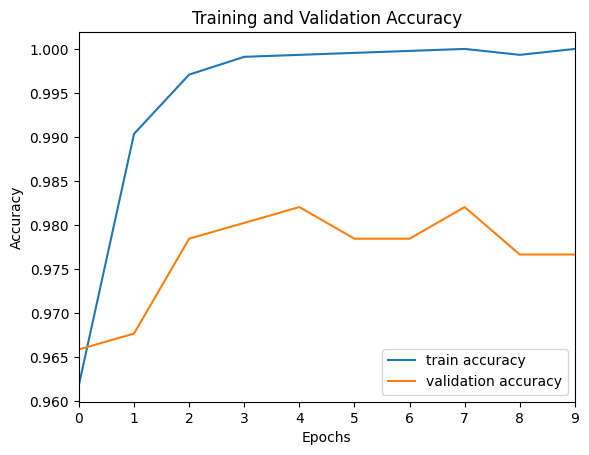

In [20]:
# Impor modul numpy dan matplotlib.pyplot
import numpy as np
import matplotlib.pyplot as plt

# Pindahkan tensor ke CPU dan konversi ke numpy array untuk akurasi pelatihan
train_acc = np.array([t.cpu().numpy() for t in history['train_acc']])

# Pindahkan tensor ke CPU dan konversi ke numpy array untuk akurasi validasi
val_acc = np.array([t.cpu().numpy() for t in history['val_acc']])

# Plot akurasi pelatihan
plt.plot(train_acc, label='train accuracy')

# Plot akurasi validasi
plt.plot(val_acc, label='validation accuracy')

# Tambahkan judul ke plot
plt.title('Training and Validation Accuracy')

# Tambahkan label untuk sumbu x
plt.xlabel('Epochs')

# Tambahkan label untuk sumbu y
plt.ylabel('Accuracy')

# Tambahkan legenda ke plot
plt.legend()

# Batasi rentang sumbu x dari 0 sampai 9
plt.xlim(0, 9)

# Tampilkan plot
plt.show()


# VISUALISASI AKURASI PELATIHAN DAN KEHILANGAN PELATIHAN (LOSS)

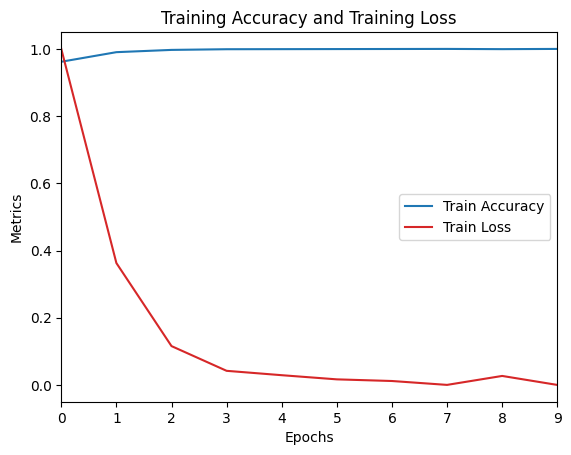

In [21]:
# Impor modul numpy dan matplotlib.pyplot
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk memindahkan tensor ke CPU dan konversi ke numpy array jika perlu
def to_numpy(tensor_or_array):
    if isinstance(tensor_or_array, torch.Tensor):
        return tensor_or_array.cpu().numpy()
    return np.array(tensor_or_array)

# Pindahkan tensor ke CPU dan konversi ke numpy array untuk akurasi pelatihan
train_acc = np.array([to_numpy(t) for t in history['train_acc']])

# Pindahkan tensor ke CPU dan konversi ke numpy array untuk kehilangan pelatihan
train_loss = np.array([to_numpy(t) for t in history['train_loss']])

# Normalisasi train_loss ke rentang yang sama dengan train_acc
train_loss_normalized = (train_loss - train_loss.min()) / (train_loss.max() - train_loss.min())

# Buat plot figure dan axis
fig, ax1 = plt.subplots()

# Plot akurasi pelatihan
ax1.plot(train_acc, label='Train Accuracy', color='tab:blue')

# Plot kehilangan pelatihan yang dinormalisasi
ax1.plot(train_loss_normalized, label='Train Loss', color='tab:red')

# Tambahkan judul ke plot
plt.title('Training Accuracy and Training Loss')

# Tambahkan label untuk sumbu x
ax1.set_xlabel('Epochs')

# Tambahkan label untuk sumbu y
ax1.set_ylabel('Metrics')

# Tambahkan legenda ke plot
ax1.legend()

# Batasi rentang sumbu x dari 0 sampai 9
ax1.set_xlim(0, 9)

# Tampilkan plot
plt.show()


# MENDIFINISIKAN FUNGSI GET PREDICTIONS UNTUK MENDAPATKAN PREDIKSI DARI MODEL

In [22]:
# mendefinisikan fungsi get_predictions untuk mendapatkan prediksi dari model pada data yang diberikan.
def get_predictions(
    model, data_loader
):
    # model dipindahkan ke mode evaluasi
    model = model.eval()

    # membuat 4 list kosong untuk menyimpan pesan, predictions, predictions_probs, dan nilai aslinya
    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        # membuat looping untuk mengakses seluruh dataset
        for d in data_loader:
            msg = d['msg']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            spam = d['spam'].to(device)

            # 
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(msg)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(spam)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

In [23]:
y_msgs, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# Creating Final Classification Report

In [24]:
# mendefinisikan fungsi
def create_classification_report(Y_test, Y_pred):
    print('--------Classification Report---------\n')
    # menghitung beberapa metrik evaluasi
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)

    # metrik-metrik tersebut dikumpulkan ke dalam daftar metrices
    metrices = [accuracy, f1, precision, recall, roc_auc]
    # membuat sebuah DataFrame pandas yang berisi metrik-metrik tersebut
    scores = pd.DataFrame(pd.Series(metrices).values, index=['accuracy', 'f1-score', 'precision', 'recall', 'roc auc score'], columns=['score'])
    print(scores)
    print('\n--------Plotting Confusion Matrix---------')
    # memplot matriks confusion (confusion matrix) menggunakan seaborn
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='RdYlGn_r', annot_kws={'size': 16})
    return scores

In [27]:
# Impor fungsi classification_report dari sklearn.metrics
from sklearn.metrics import classification_report

# Asumsikan y_test adalah label yang benar dan y_pred adalah prediksi model
# Buat laporan klasifikasi
report = classification_report(y_test, y_pred)

# Cetak laporan klasifikasi
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       481
           1       1.00      0.99      0.99        77

    accuracy                           1.00       558
   macro avg       1.00      0.99      1.00       558
weighted avg       1.00      1.00      1.00       558



# Melakukan Prediksi SPAM dari Pesan yang Diinput

In [32]:
# mendefinisikan fungsi AMBIL MODEL YANG TELAH DISIMPAN DI MEMORI
def load_model(model_path, n_classes):
    # membuat instance dari kelas SpamClassifier dengan jumlah kelas n_classes
    model = SpamClassifier(n_classes)
    # memuat model latih ke dalam instance
    model.load_state_dict(torch.load(model_path, map_location=device))
    # memindahkan model ke GPU or CPU
    model = model.to(device)
    # mengatur mode evaluasi pada model
    model.eval()
    return model

# mendefinisikan fungsi PROSES INPUTAN TEXT
def preprocess_text(text, tokenizer, max_len):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding['input_ids'].flatten(), encoding['attention_mask'].flatten()

# mendefinisikan fungsi PREDIKSI SPAM
def predict_spam(model, tokenizer, text, max_len, device):
    input_ids, attention_mask = preprocess_text(text, tokenizer, max_len)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
    _, prediction = torch.max(outputs, dim=1)
    return prediction.item()

# Test with user input
user_input = input("Enter a message to classify as spam or not spam: ")
prediction = predict_spam(model, tokenizer, user_input, MAX_LEN, device)

if prediction == 1:
    print("The message is spam.")
else:
    print("The message is not spam.")


Enter a message to classify as spam or not spam:  think ur smart win week weekly quiz text play c winnersclub po box uz gbp week


The message is spam.
